# Normality tests

The question that matters is not whether the data were sampled from an ideal Gaussian population, which is impossible by nature, but rather whether the **distribution from which they were sampled is close enough to the Gaussian ideal** that the results of the statistical tests are still usefull. Indeed, these tests are fairly robust to violations of the Gaussian assumption, especially if the sample sizes are large and equal.

## What a Gaussian distribution really looks like

The figure below shows the distribution of values randomly chosen from a Gaussian distribution, with the same mean and SD. The top graphs show samples with 12 values in each sample, and the bottom graphs show samples with 130 values. Because of random sampling, none of those distributions really looks completely bell shaped and symmetrical.

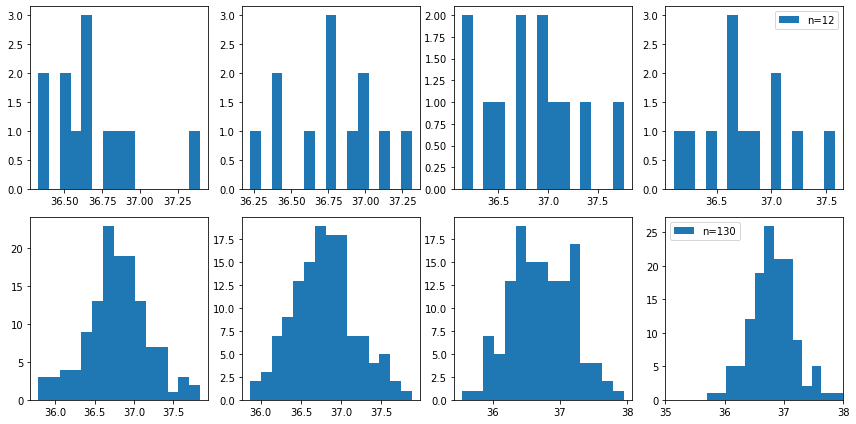

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

np.random.seed(111)

# set the mean and sdt temperature for random sampling
mean_temp = 36.8
std_temp = 0.4 

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,6))

for graph in range(4):
    axes[0,graph].hist(ss.norm(loc=mean_temp, scale=std_temp).rvs(size=12), label="n=12", bins=15)

for graph in range(4):
    axes[1,graph].hist(ss.norm(loc=mean_temp, scale=std_temp).rvs(size=130),label="n=130",bins=15)

axes[0,3].legend()
axes[1,3].legend()

plt.xlim((35,38))
plt.tight_layout()

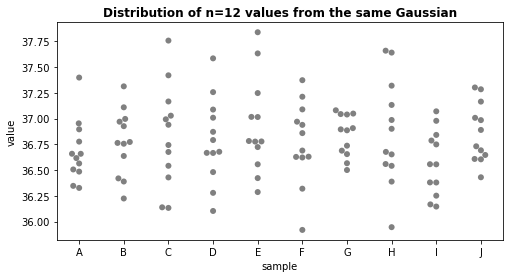

In [2]:
import pandas as pd
import seaborn as sns

np.random.seed(111)

distrib = pd.DataFrame(
   {label: ss.norm(loc=mean_temp, scale=std_temp).rvs(size=12) for label in 'ABCDEFGHIJ'}
)

plt.figure(figsize=(8,4))
sns.swarmplot(
    x='variable',
    y='value',
    data=distrib.melt(),
    color='grey',
    size=6,
)

plt.xlabel("sample")
plt.title("Distribution of n=12 values from the same Gaussian", fontweight='bold');

## QQ plots

There exists several methods to test for normality and we recommend to combine a graphical method 
with a classic statistical test in order to get the best view of one's data.

You can get a graphical overview of the goodness-of-fit of a sample with a Quantile-Quantile-plot, or **QQplot**. 
The idea here is to compute a number of quantiles on your sample's values and plot them with the expected quantiles for the normal law.
**Samples drawn from a normal law will form a diagonal line.**

The Y axis plots the actual values in a sample of data, the X axis plots ideal predicted values assuming the data were sampled from a Gaussian distribution. First the program computes the percentile of each value in the data set. Next, for each percentile, it calculates how many SDs from the mean you need to go to reach that percentile on a Gaussian distribution. Finally, using the actual mean and SD computed from the data, it calculates the corresponding predicted value.

Text(0.5, 1.0, 'Probability plot - Exponential distribution vs. Gaussian')

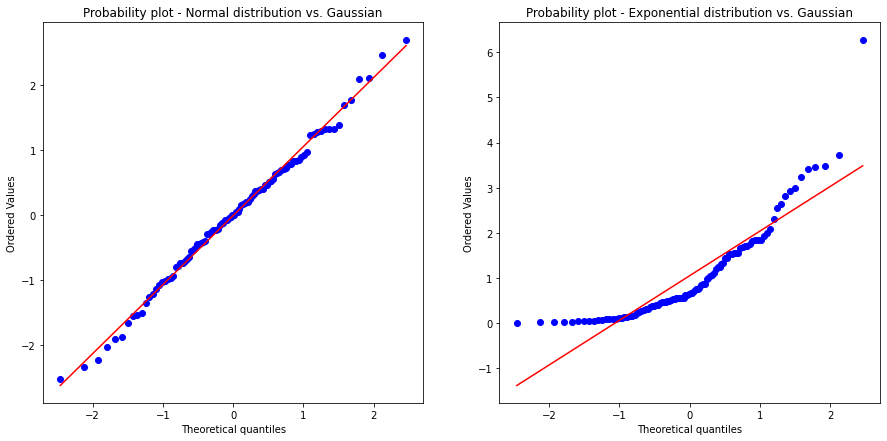

In [3]:
sampleN = np.random.normal(size=100)      #sample from a normal law
sampleE = np.random.exponential(size=100) #sampling from exponential distribution

fig,axes = plt.subplots(1,2, figsize=(15,7))
junk = ss.probplot(sampleN, plot=axes[0])
axes[0].set_title('Probability plot - Normal distribution vs. Gaussian')

junk = ss.probplot(sampleE, plot=axes[1])
axes[1].set_title('Probability plot - Exponential distribution vs. Gaussian')
# note : stats.probplot plots against the normal law by default, but that can be changed

### Q-Q plot using pingouin package

See also the [full description](https://pingouin-stats.org/generated/pingouin.qqplot.html#pingouin.qqplot).

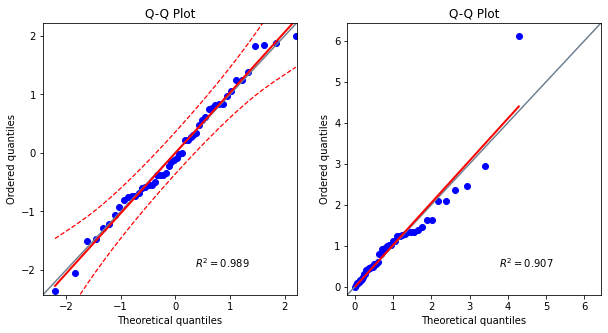

In [4]:
import pingouin as pg

np.random.seed(123)

x = np.random.normal(size=50)
x_exp = np.random.exponential(size=50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1 = pg.qqplot(x,     dist='norm',  ax=ax1, confidence=.95)
ax2 = pg.qqplot(x_exp, dist='expon', ax=ax2, confidence=False)

## Testing for normality

Statistical tests can be used to quantify how much a data set deviates from the expectations of a Gaussian distribution.

However, with tiny samples (three of four values), it really is impossible to make useful inferences about the distribution of the population.

### D'Agostino-Pearson omnibus K2 normality tests

It tests the null hypothesis that a sample comes from a normal distribution. It combines Skewness, which quantifies symmetry (symmetrical distributions have s~0) and Kurtosis, which measures the presence of values in the tails of the distribution (distributions with more values in the tails, i.e. outliers, than a Gaussian have k>0) to produce an omnibus test of normality.

In [5]:
from scipy.stats import kurtosis, skew

print('normal data', f"Skewness={skew(sampleN):.3f}", f"Kurtosis={kurtosis(sampleN):.3f}", sep='\t')
print('exponential', f"Skewness={skew(sampleE):.3f}", f"Kurtosis={kurtosis(sampleE):.3f}", sep='\t')

normal data	Skewness=-0.024	Kurtosis=0.004
exponential	Skewness=1.815	Kurtosis=4.642


In [6]:
# see also scipy.stats.describe
ss.describe(sampleN)

DescribeResult(nobs=100, minmax=(-2.5332642503224903, 2.6936055445138005), mean=-0.012867062216298148, variance=1.0989775277257918, skewness=-0.024172639735987836, kurtosis=0.0035752285817642893)

The normality test computes a P value that answer the question: if randomly sample from a Gaussian population, what is the probability of obtaining a sample that deviates from a Gaussian population as much as or more so than the sample does? If the **P value from a normality test is large**, the **data are not inconsistent with a Gaussian distribution**. All the normality tests can do is demonstrate that the deviation from the Gaussian ideal is not more than you'd expect   to see from chance alone.

In [7]:
k2, pval = ss.normaltest(sampleN) # returns k2 = s^2 + k^2
                                  # where s is the z-score returned by skewtest
                                  # and k is the z-score returned by kurtosistest
print('normal data', f"D'Agostino-Pearson omnibus K2={k2:.2f}", f"p-value={pval:.3f}", sep='\t')

k2, pval = ss.normaltest(sampleE)
print('exponential', f"D'Agostino-Pearson omnibus K2={k2:.2f}", f"p-value={pval:.3f}", sep='\t')

normal data	D'Agostino-Pearson omnibus K2=0.12	p-value=0.942
exponential	D'Agostino-Pearson omnibus K2=50.10	p-value=0.000


### Shapiro-Wilk test

It has been shown to have a slighly better power than other tests by a [2011 study](https://web.archive.org/web/20150630110326/http://instatmy.org.my/downloads/e-jurnal%202/3.pdf).

This test relies on the comparison between each sorted point in the observed distribution and its expected value in a normal distribution. 
Originally proposed for no more than 50 points, refinements to the algorithm now makes this test reliable up to 5000 points (as mentionned in `help(scipy.stats.shapiro)`); above this number another test, such as D'Agostino's, should be used instead.

In [8]:
tstat, pval = ss.shapiro(sampleN)
print('normal data     ', "Shapiro-Wilk's normality test p-value", pval, sep='\t')
tstat, pval = ss.shapiro(sampleE)
print('exponential data', "Shapiro-Wilk's normality test p-value", pval, sep='\t')

normal data     	Shapiro-Wilk's normality test p-value	0.9421863555908203
exponential data	Shapiro-Wilk's normality test p-value	1.4438069628752714e-09


### Kolmogorov-Smirnov test

The Kolmogorov-Smirnov is a **nonparametric test that compares entire distributions**.
It can either be used to compare the distribution of samples, or the distribution of a single sample with a distribution of reference.

Contrary to the t-test which is only a test of location, the **KS test also differentiate differences in scale and shape**.

The statistic of the Kolmogorov-smirnov test corresponds to the maximal distance between the cumulative distribution functions of the sample and the reference distribution (1-sample test) or the second sample (2-sample test).

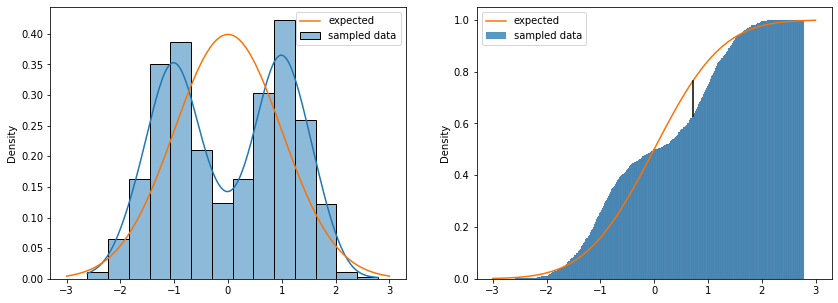

In [9]:
sampleSize=1000
sample=np.random.randn(sampleSize) * 0.5 + 1 - 2 * (np.random.random(sampleSize)>0.5) # BIMODAL DISTRIBUTION

# computing the observed CDF and comparing with what is expected under a normal distribution

def ecdf(data):
    """Compute ECDF (Empirical Cumulative Distributive Function) for a one-dimensional array of values."""
    n=len(data)
    x=np.sort(data)
    y=np.arange(1,n+1)/n
    return x,y

sample, cdfobserved = ecdf(sample)
cdfexpected = ss.norm.cdf(sample)

diff = abs(cdfexpected-cdfobserved)
positionMax = np.argmax(diff) 
maxDiff = diff[positionMax]
maxPos = sample[positionMax]

# plotting the pdf and cdf 
x = np.linspace(-3,3,100)
fig,axes = plt.subplots(1,2,figsize=(14,5))
sns.histplot(sample, label='sampled data', stat='density', kde=True, ax=axes[0])
sns.lineplot(x=x, y=ss.norm.pdf(x), color='xkcd:orange', label='expected', ax=axes[0])
          
sns.histplot(sample, bins=len(sample), stat='density', 
             cumulative=True, label='sampled data', ax=axes[1]).set_zorder(1)
sns.lineplot(x=x, y=ss.norm.cdf(x), color='xkcd:orange', label='expected', ax=axes[1])
#adding a segment to visualize the KS statistic
axes[1].plot([maxPos,maxPos], [cdfobserved[positionMax],cdfexpected[positionMax]], color='black');

In [11]:
np.abs(cdfobserved[positionMax] - cdfexpected[positionMax])
# this difference corresponds to the KS test statistic

0.13782028955273884

In [12]:
ksStat,pvalue = ss.kstest(sample, ss.norm.cdf)
print('1-sample Kolmogorov-Smirnov test:')
print(f"KS test statistic = {ksStat:.3f}")
print(f"p-value = {pvalue:.5f}")

1-sample Kolmogorov-Smirnov test:
KS test statistic = 0.139
p-value = 0.00000


# Outliers

An outlier is a value that is so far from the others that it appears to have come from a different population.
They can occur for several reasons:

* invalid data entry
* biological diversity
* random chance
* experimental mistake
* invalid assumption, i.e. lognormal distribution instead of Gaussian



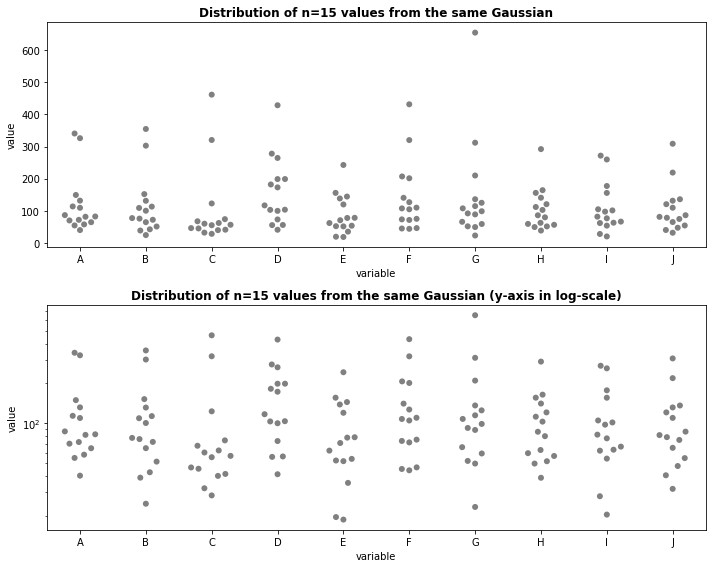

In [13]:
np.random.seed(333)

distrib = pd.DataFrame(
   {label: ss.lognorm(s=.8, loc=10, scale=80).rvs(size=15) for label in 'ABCDEFGHIJ'}
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

sns.swarmplot(
    x='variable',
    y='value',
    data=distrib.melt(),
    color='grey',
    size=6,
    ax=axes[0]
).set_title("Distribution of n=15 values from the same Gaussian", fontweight='bold')

sns.swarmplot(
    x='variable',
    y='value',
    data=distrib.melt(),
    color='grey',
    size=6,
    ax=axes[1],
).set_title("Distribution of n=15 values from the same Gaussian (y-axis in log-scale)", fontweight='bold')
axes[1].set_yscale('log')
plt.tight_layout();

The Grubb’s test is a statistical method to identify an outlier in a univariate dataset that follows a roughly Normal distribution.
The G-statistic, which is similar to the Z-statistic or the T-statistic, and is also called the extreme studentized deviate test, divides the difference between the extreme value and the mean of **all values** by the SD of all valuesµ: $$G = \frac{\text{outlier} - \text{mean}}{\text{SD}}$$
Then we compare the G-value with a table of critical values with threshold values based on the number of observations and confidence level.
With G-statistic > threshold, the data is considered as an outlier.

![Values of Grubbs Statistic (G)](https://cdn.slidesharecdn.com/ss_thumbnails/statisticstablesgrubbstest-150209143458-conversion-gate02-thumbnail-4.jpg?cb=1423492541)

A **box plot** is an excellent tool for exploratory data analysis to easily make comparisons between distributions. A value is considered an outlier if it falls outside the $\text{Q1} - 1.5 \times \text{IQR}$ / $\text{Q3} + 1.5 \times \text{IQR}$ range and is represented in a box plot with a dot, with IQR (**interquartile range**) = Q3 - Q1.

**Residual plots** derived from a regression fitting may also be usefull as outliers present large residual values because they are far away from the regression line.

Other outliers detection methods exist, e.g. using [scikit-learn](https://scikit-learn.org/stable/modules/outlier_detection.html). For example, the **Cook's distance** measures the effect of deleting a given observation in regression analysis. Put another way, it is a way to **detect data points that significantly modify the regression coefficients** (highly influential data).

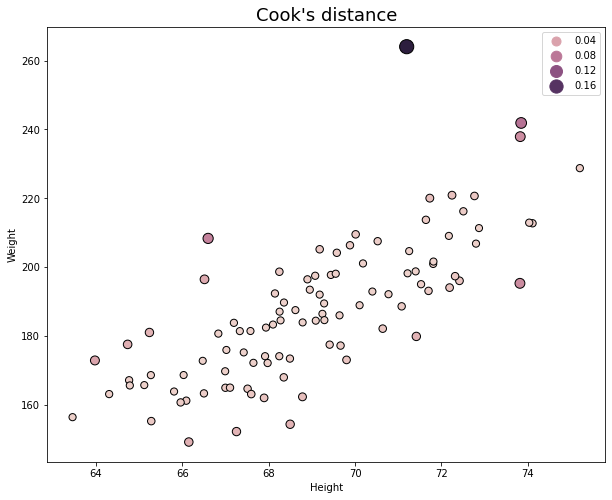

In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence

# generate data
df_weight = pd.read_csv("C:/Users/Sébastien/Documents/data_science/biostatistics/Intuitive_biostatistics_4th/data/weight-height.csv")
df_weight=df_weight[:100] # we take only the 100 first rows
df_weight.loc[10, 'Weight'] = df_weight['Weight'].mean() + 4 * df_weight['Weight'].std() # we create one outlier

# fit the regression model using statsmodels library 
f = 'Weight ~ Height'
model = ols(formula=f, data=df_weight).fit()

# calculate the cooks_distance - the OLSInfluence object contains multiple influence measurements
cook_distance = OLSInfluence(model).cooks_distance
(distance, p_value) = cook_distance

plt.figure(figsize=(10,8))
# scatter plot - x axis (independent variable height), y-axis (dependent variable weight), size and color of the marks according to its cook's distance
sns.scatterplot(x=df_weight.Height, y=df_weight.Weight, hue=distance, size=distance, sizes=(50, 200), edgecolor='black', linewidth=1)

plt.title('Cook\'s distance', fontsize=18);

However, rather than removing outliers, consider using robust statistical methods that are not much influenced by the presence of outliers, i.e. median instead of mean.